## 1. Set up

1 - Mount Drive

In [75]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2 - Move to the data folder

In [ ]:
cd "gdrive/MyDrive/Projects/1 - Numericals/Autism Prediction Challenge/2 - Production/data"

/content/gdrive/MyDrive/Projects/1 - Numericals/Autism Prediction Challenge/2 - Production/data


### 2. Libraries

In [ ]:
# Load data
import pandas as pd
import numpy as np
import io
import os
import glob

# Meta
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display

# Split Data
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# Metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


### 3. Data

In [ ]:
ls

Autism-prediction/     l1_clean_encoded.csv   sample_submission.csv  train.csv
autism-prediction.zip  l1_clean_unecoded.csv  test.csv


In [ ]:
# Load sales_train in both encoded and unencoded forms
df = pd.read_csv('l1_clean_encoded.csv')

### 4. Split data into train and validation 

In [ ]:
X = df.drop(['Class/ASD'], axis=1)
y = df['Class/ASD']

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.2, 
                                                  random_state = 0)

In [ ]:
print('x_train', x_train.shape)
print('x_valid:', x_valid.shape)
print('y_train', y_train.shape)
print('y_valid:', y_valid.shape)

x_train (640, 21)
x_valid: (160, 21)
y_train (640,)
y_valid: (160,)


### 5. Functions

In [ ]:
# Code attribution : https://www.codegrepper.com/code-examples/python/convert+bytes+to+mb+python
def convertFloatToDecimal(self, f=0.0, precision=2):
    '''
    Function: Convert a float to string of decimal.
    precision: by default 2.
    If no arg provided, return "0.00".
    '''
    return ("%." + str(precision) + "f") % f


# Code attribution : https://www.codegrepper.com/code-examples/python/convert+bytes+to+mb+python
def formatFileSize(self, size, sizeIn, sizeOut, precision=0):
  '''
  Function: Convert file size to a string representing its value in B, KB, MB and GB.
  The convention is based on sizeIn as original unit and sizeOut
  as final unit. 
  '''
  assert sizeIn.upper() in {"B", "KB", "MB", "GB"}, "sizeIn type error"
  assert sizeOut.upper() in {"B", "KB", "MB", "GB"}, "sizeOut type error"
  if sizeIn == "B":
      if sizeOut == "KB":
          return self.convertFloatToDecimal((size/1024.0), precision)
      elif sizeOut == "MB":
          return self.convertFloatToDecimal((size/1024.0**2), precision)
      elif sizeOut == "GB":
          return self.convertFloatToDecimal((size/1024.0**3), precision)
  elif sizeIn == "KB":
      if sizeOut == "B":
          return self.convertFloatToDecimal((size*1024.0), precision)
      elif sizeOut == "MB":
          return self.convertFloatToDecimal((size/1024.0), precision)
      elif sizeOut == "GB":
          return self.convertFloatToDecimal((size/1024.0**2), precision)
  elif sizeIn == "MB":
      if sizeOut == "B":
          return self.convertFloatToDecimal((size*1024.0**2), precision)
      elif sizeOut == "KB":
          return self.convertFloatToDecimal((size*1024.0), precision)
      elif sizeOut == "GB":
          return self.convertFloatToDecimal((size/1024.0), precision)
  elif sizeIn == "GB":
      if sizeOut == "B":
          return self.convertFloatToDecimal((size*1024.0**3), precision)
      elif sizeOut == "KB":
          return self.convertFloatToDecimal((size*1024.0**2), precision)
      elif sizeOut == "MB":
          return self.convertFloatToDecimal((size*1024.0), precision)

In [ ]:
# Function to calculate the time taken to run the function that calls it
def find_time_taken(begin, end):
  '''
  Function: Calculate the time taken to run this procedure
  Input: Beginning time, ending time
  Action: Calculate the time taken for a procedure to be run in minutes or seconds
  '''
  time_taken = end - begin

  if time_taken >= 60:
    time_taken = round(time_taken/60,2)
    print("Time taken to run this procedure:",time_taken,"minutes")
  else:
    time_taken = round(time_taken,2)
  print('\n')
  print("Time taken to run this procedure:",time_taken,"seconds")

In [115]:
def print_score(model):
  begin = time.time()
  predictions_train = model.predict(x_train)
  print('Train ROC-AUC Score:',round(roc_auc_score(y_train, predictions_train),4))

  predictions_valid = model.predict(x_valid)
  print('ValidationROC-AUC Score:',round(roc_auc_score(y_valid, predictions_valid),4))
  end = time.time()
  find_time_taken(begin, end)


In [ ]:
def feature_importances_details(df):
  column_name = 'Importances_Percent'

  min = df[column_name].min()
  q1 = df[column_name].quantile(0.25)
  q2 = df[column_name].quantile(0.50)
  q3 = df[column_name].quantile(0.75)
  max = df[column_name].max()
  print('Quartile 1:', q1)
  print('Quartile 2:', q1)
  print('Quartile 3:', q1)
  print('Maximum:', max)
  print('Min:', min)


In [ ]:
def get_drop_columns(df, importance):
  keep_features = feature_importances[feature_importances.Importances_Percent>importance]
  drop_features = feature_importances[feature_importances.Importances_Percent<=importance]
  drop_features = drop_features['Features'].tolist()
  return drop_features

In [126]:
def get_feature_importances(x_train, model):
  feature_importances = pd.DataFrame({'Features': x_train.columns, 'Importances_Percent': model.feature_importances_}, columns=['Features', 'Importances_Percent', 'Change'])
  feature_importances['Importances_Percent'] = round(feature_importances['Importances_Percent'] * 100,2)
  feature_importances = feature_importances.sort_values(by='Importances_Percent', ascending=False)
  feature_importances['Change'] = round(feature_importances['Importances_Percent'].pct_change(),2)
  return feature_importances


##2. Data Assessment with Random Forests

### 1. Find the right hyper-parameters

1. Create a base model

In [ ]:
base_model = RandomForestClassifier(n_jobs = -1)
%time base_model.fit(x_train, y_train)

CPU times: user 337 ms, sys: 13.9 ms, total: 351 ms
Wall time: 568 ms


RandomForestClassifier(n_jobs=-1)

In [ ]:
print_score(base_model)

ROC-AUC Score: 0.77


Time taken to run this procedure: 0.11 seconds


2. Create a sample model with random hyperparameters

In [ ]:
random_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_leaf=3, max_samples=0.5, max_features=0.5)
%time random_model.fit(x_train, y_train)
print_score(random_model)

CPU times: user 734 ms, sys: 13.2 ms, total: 747 ms
Wall time: 787 ms
ROC-AUC Score: 0.75


Time taken to run this procedure: 0.11 seconds


3. Use the grid search to find good parameters



In [ ]:
begin = time.time()
clf = RandomForestClassifier(n_jobs=-1)

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'min_samples_leaf': [1,2,3,5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
Accuracy score on testing data: 0.8625
F-score on testing data: 0.7701

Optimized Model
------
Final accuracy score on the testing data: 0.8500
Final F-score on the testing data: 0.7444


Time taken to run this procedure: 24.25 seconds


In [ ]:
# Print the best parameters for this job
best_clf 

RandomForestClassifier(min_samples_leaf=5, n_jobs=-1)

In [ ]:
m = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 300 ms, sys: 8.62 ms, total: 308 ms
Wall time: 393 ms
ROC-AUC Score: 0.74


Time taken to run this procedure: 0.13 seconds


### 2 - Feature Importances

1. Get feature importances

In [ ]:
feature_importances = pd.DataFrame({'Features': x_train.columns, 'Importances_Percent': m.feature_importances_}, columns=['Features', 'Importances_Percent', 'Change'])
feature_importances['Importances_Percent'] = round(feature_importances['Importances_Percent'] * 100,2)
feature_importances = feature_importances.sort_values(by='Importances_Percent', ascending=False)
feature_importances['Change'] = round(feature_importances['Importances_Percent'].pct_change(),2)

In [ ]:
feature_importances

,Features,Importances_Percent,Change
19,final_score,17.00,NaN
4,A3_Score,13.43,-0.21
7,A6_Score,10.78,-0.20
5,A4_Score,10.14,-0.06
10,A9_Score,9.71,-0.04
11,A10_Score,4.86,-0.50
6,A5_Score,4.77,-0.02
1,ID,4.14,-0.13
0,Unnamed: 0,4.06,-0.02
14,ethnicity,3.68,-0.09


<BarContainer object of 21 artists>

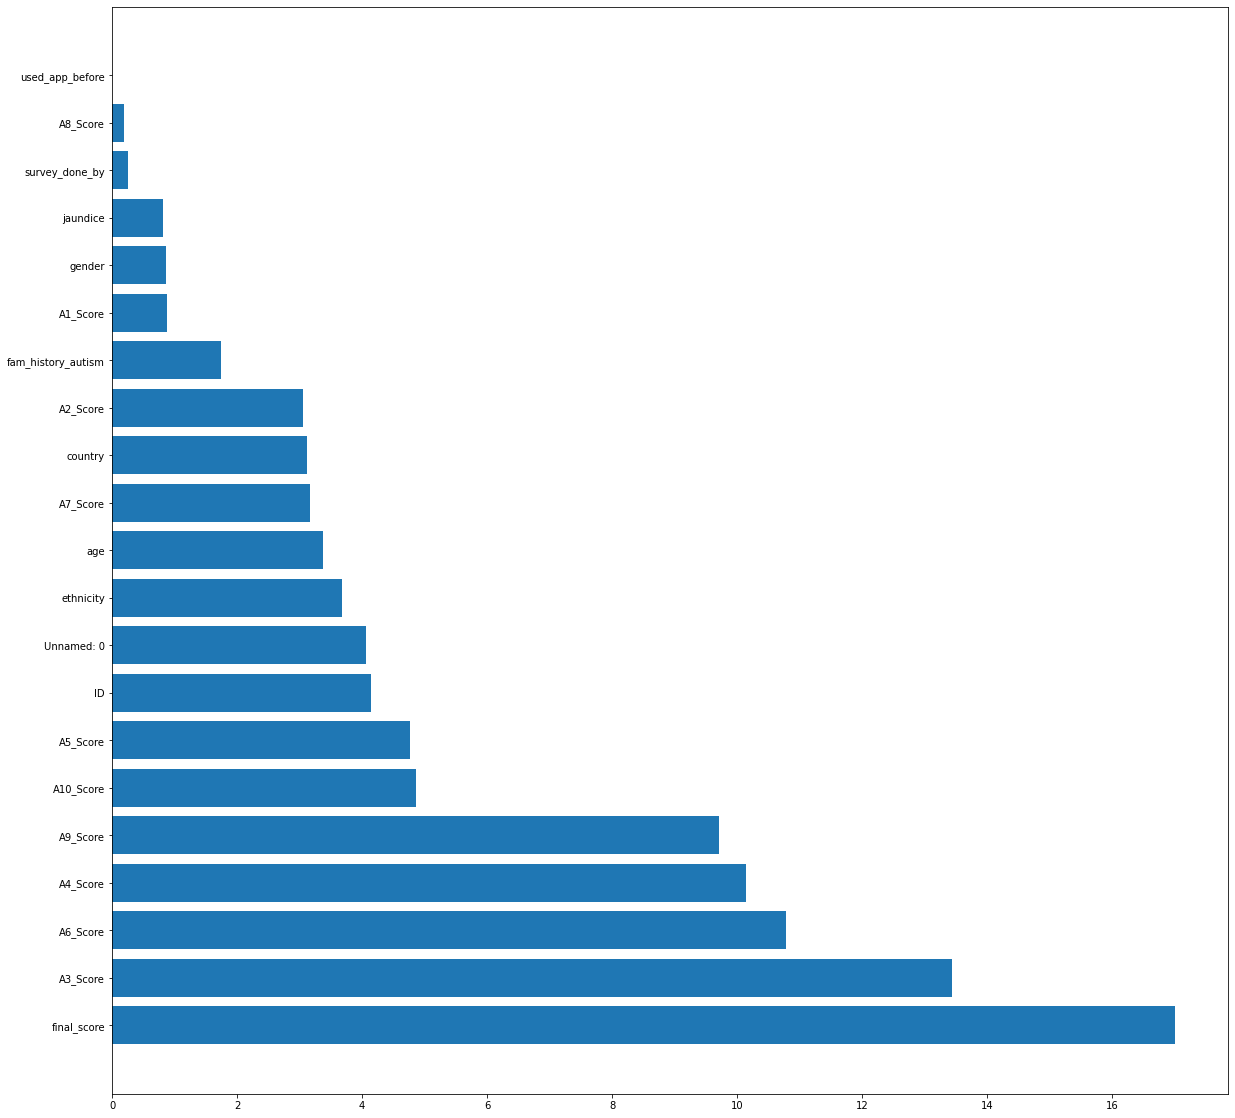

In [ ]:
fig = plt.figure(figsize = (20, 20))
plt.barh(feature_importances['Features'], feature_importances['Importances_Percent'])

2 - Model experiment 1 - Drop features with importance less than or equal 0.26

In [ ]:
drop_features = get_drop_columns(x_train, 0.26)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [ ]:
x_train.shape

(640, 18)

In [ ]:
begin = time.time()
clf = RandomForestClassifier(n_jobs=-1)

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'min_samples_leaf': [1,2,3,5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
Accuracy score on testing data: 0.8500
ROC-AUC on testing data: 0.7531

Optimized Model
------
Final accuracy score on the testing data: 0.8500
Final ROC-AUC on the testing data: 0.7444


Time taken to run this procedure: 29.49 seconds


3 - Model experiment 2 - Drop features with importance less than or equal to 3.06

In [83]:
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.2, 
                                                  random_state = 0)

In [84]:
drop_features = get_drop_columns(x_train, 3.06)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [85]:
x_train.shape

(640, 13)

In [87]:
begin = time.time()
clf = RandomForestClassifier(n_jobs=-1)

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'min_samples_leaf': [1,2,3,5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
ROC-AUC score on train data: 1.0000
ROC-AUC on testing data: 0.7444

Optimized Model
------
Final ROC-AUC on the train data: 1.0000
Final ROC-AUC on the testing data: 0.7742


Time taken to run this procedure: 24.06 seconds


In [88]:
best_clf

RandomForestClassifier(min_samples_leaf=3, n_estimators=40, n_jobs=-1)

In [89]:
m = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 134 ms, sys: 2.79 ms, total: 136 ms
Wall time: 184 ms
ROC-AUC Score: 0.77


Time taken to run this procedure: 0.11 seconds


4 - Model experiment 3 - Drop features with importance less than or equal to 3.16

In [90]:
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.2, 
                                                  random_state = 0)


In [91]:
drop_features = get_drop_columns(x_train, 3.16)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [92]:
x_train.shape

(640, 11)

In [93]:
begin = time.time()
clf = RandomForestClassifier(n_jobs=-1)

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'min_samples_leaf': [1,2,3,5]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
ROC-AUC score on train data: 1.0000
ROC-AUC on testing data: 0.7701

Optimized Model
------
Final ROC-AUC on the train data: 1.0000
Final ROC-AUC on the testing data: 0.7701


Time taken to run this procedure: 25.9 seconds


In [94]:
best_clf

RandomForestClassifier(min_samples_leaf=5, n_estimators=20, n_jobs=-1)

In [95]:
m = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 65.9 ms, sys: 3 ms, total: 68.9 ms
Wall time: 121 ms
ROC-AUC Score: 0.77


Time taken to run this procedure: 0.11 seconds


##3. Data Assessment with XG Boost

In [98]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

### 1 - Model experiment 1 - Base Model

1. Split data

In [131]:
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.2, 
                                                  random_state = 0)


2. Find parameters

In [132]:
begin = time.time()
clf = xgb.XGBRegressor(objective ='reg:logistic')

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'learning_rate': [0.1, 0.01, 0.001, 0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
ROC-AUC score on train data: 0.9868
ROC-AUC on testing data: 0.8777

Optimized Model
------
Final ROC-AUC on the train data: 0.9868
Final ROC-AUC on the testing data: 0.8782


Time taken to run this procedure: 3.36 seconds


In [133]:
best_clf

XGBRegressor(n_estimators=40, objective='reg:logistic')

In [134]:
m = XGBRegressor(n_estimators=40, objective='reg:logistic')
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 35.4 ms, sys: 836 µs, total: 36.2 ms
Wall time: 36 ms
Train ROC-AUC Score: 0.9679
ValidationROC-AUC Score: 0.8782


Time taken to run this procedure: 0.01 seconds


3. Get feature importances

In [135]:
feature_importances = pd.DataFrame({'Features': x_train.columns, 'Importances_Percent': m.feature_importances_}, columns=['Features', 'Importances_Percent', 'Change'])
feature_importances['Importances_Percent'] = round(feature_importances['Importances_Percent'] * 100,2)
feature_importances = feature_importances.sort_values(by='Importances_Percent', ascending=False)
feature_importances['Change'] = round(feature_importances['Importances_Percent'].pct_change(),2)

In [136]:
feature_importances

,Features,Importances_Percent,Change
4,A3_Score,27.870001,NaN
7,A6_Score,16.379999,-0.41
10,A9_Score,8.600000,-0.47
5,A4_Score,6.880000,-0.20
19,final_score,6.430000,-0.07
11,A10_Score,4.340000,-0.33
6,A5_Score,3.700000,-0.15
9,A8_Score,3.140000,-0.15
16,fam_history_autism,3.070000,-0.02
14,ethnicity,2.910000,-0.05


<BarContainer object of 21 artists>

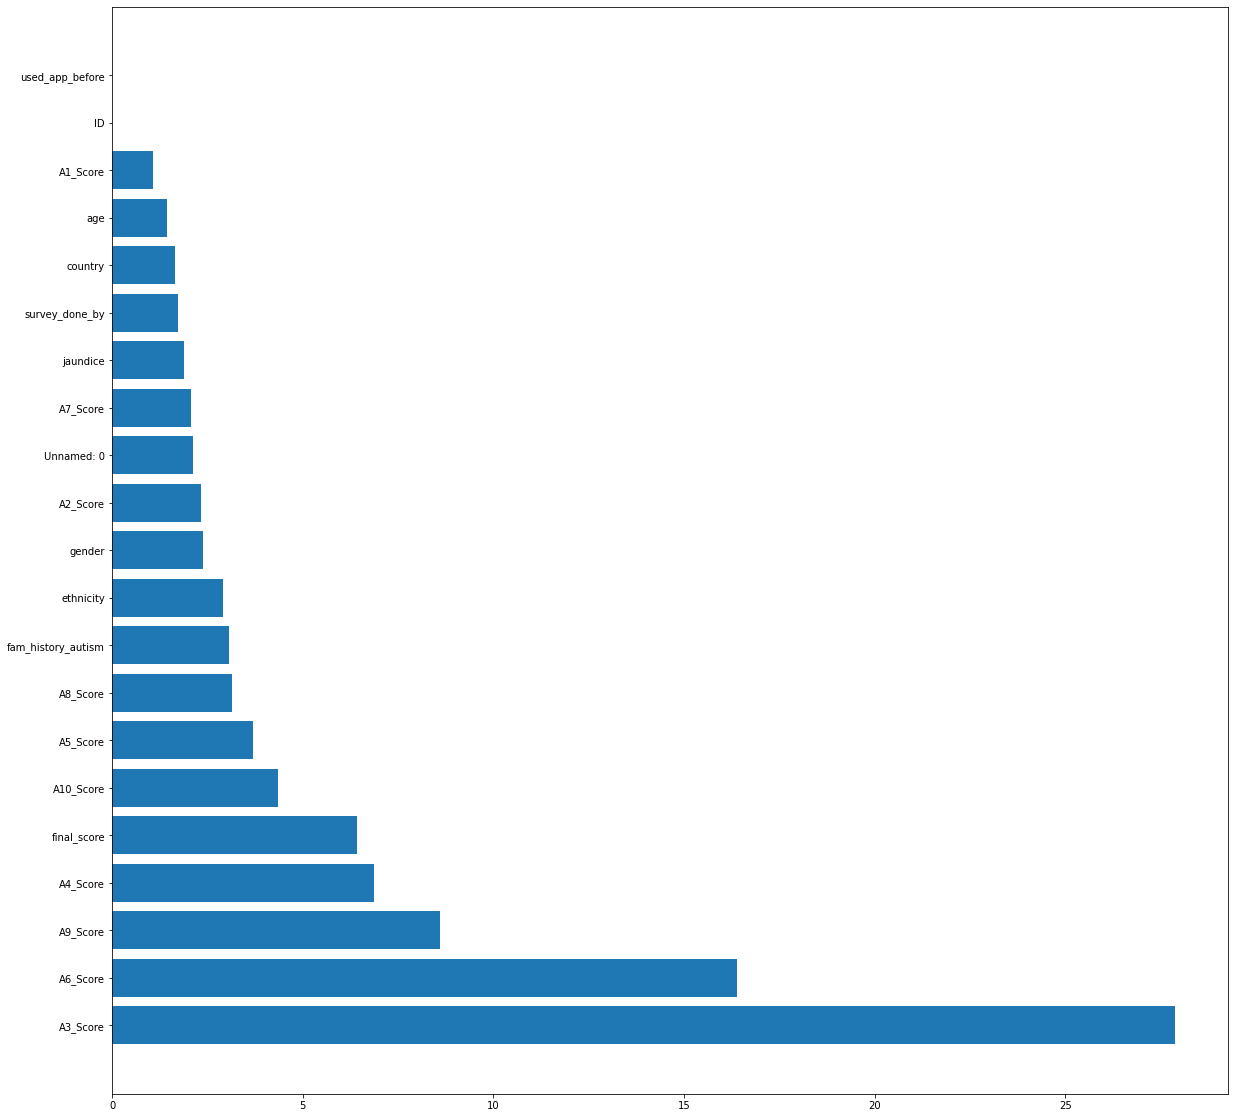

In [137]:
fig = plt.figure(figsize = (20, 20))
plt.barh(feature_importances['Features'], feature_importances['Importances_Percent'])

### 2 - Model experiment 1 - Drop features with importance less than or equal to 2.39

1. Drop features

In [138]:
drop_features = get_drop_columns(x_train, 2.39)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [139]:
x_train.shape

(640, 10)

2. Find parameters

In [140]:
begin = time.time()
clf = xgb.XGBRegressor(objective ='reg:logistic')

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'learning_rate': [0.1, 0.01, 0.001, 0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
ROC-AUC score on train data: 0.9697
ROC-AUC on testing data: 0.8601

Optimized Model
------
Final ROC-AUC on the train data: 0.9697
Final ROC-AUC on the testing data: 0.8897


Time taken to run this procedure: 2.33 seconds


In [141]:
best_clf

XGBRegressor(n_estimators=20, objective='reg:logistic')

3. Get feature importances

In [142]:
m = XGBRegressor(n_estimators=20, objective='reg:logistic')
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 21.8 ms, sys: 3 µs, total: 21.8 ms
Wall time: 24.2 ms
Train ROC-AUC Score: 0.9341
ValidationROC-AUC Score: 0.8897


Time taken to run this procedure: 0.01 seconds


In [143]:
feature_importances = get_feature_importances(x_train, m)

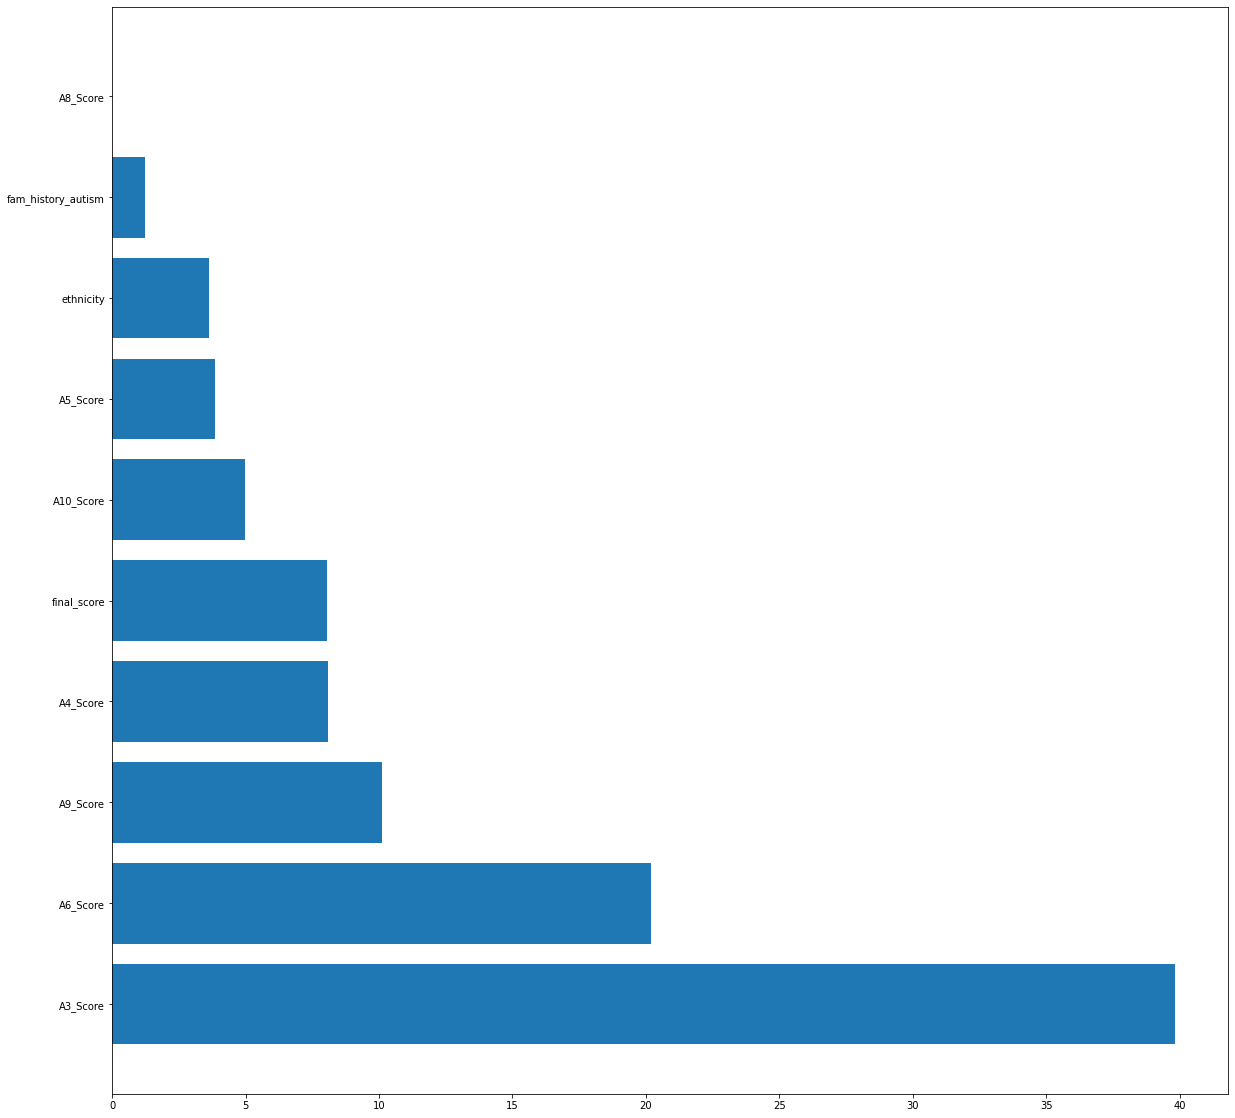

In [144]:
fig = plt.figure(figsize = (20, 20))
plt.barh(feature_importances['Features'], feature_importances['Importances_Percent'])
plt.show()

In [145]:
feature_importances

,Features,Importances_Percent,Change
0,A3_Score,39.820000,NaN
3,A6_Score,20.200001,-0.49
5,A9_Score,10.120000,-0.50
1,A4_Score,8.090000,-0.20
9,final_score,8.050000,-0.00
6,A10_Score,4.980000,-0.38
2,A5_Score,3.870000,-0.22
7,ethnicity,3.640000,-0.06
8,fam_history_autism,1.240000,-0.66
4,A8_Score,0.000000,-1.00


In [146]:
# Drop features
drop_features = get_drop_columns(x_train, 1.24)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [147]:
x_train.shape

(640, 8)

In [148]:
# Find parameters

begin = time.time()
clf = xgb.XGBRegressor(objective ='reg:logistic')

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'learning_rate': [0.1, 0.01, 0.001, 0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)

Unoptimized model
------
ROC-AUC score on train data: 0.9694
ROC-AUC on testing data: 0.8500

Optimized Model
------
Final ROC-AUC on the train data: 0.9694
Final ROC-AUC on the testing data: 0.8913


Time taken to run this procedure: 2.17 seconds


In [149]:
# Get parameters
best_clf

XGBRegressor(n_estimators=20, objective='reg:logistic')

In [150]:
# Get parameters
best_clf

XGBRegressor(n_estimators=20, objective='reg:logistic')

In [151]:
# Build model
m = XGBRegressor(n_estimators=20, objective='reg:logistic')
%time m.fit(x_train, y_train)
print_score(m)


CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 19.4 ms
Train ROC-AUC Score: 0.9352
ValidationROC-AUC Score: 0.8913


Time taken to run this procedure: 0.01 seconds


In [152]:
# Get feature importances
feature_importances = get_feature_importances(x_train, m)

In [154]:
feature_importances

,Features,Importances_Percent,Change
0,A3_Score,39.630001,NaN
3,A6_Score,20.770000,-0.48
4,A9_Score,11.780000,-0.43
7,final_score,7.340000,-0.38
1,A4_Score,7.070000,-0.04
5,A10_Score,4.980000,-0.30
2,A5_Score,4.280000,-0.14
6,ethnicity,4.150000,-0.03


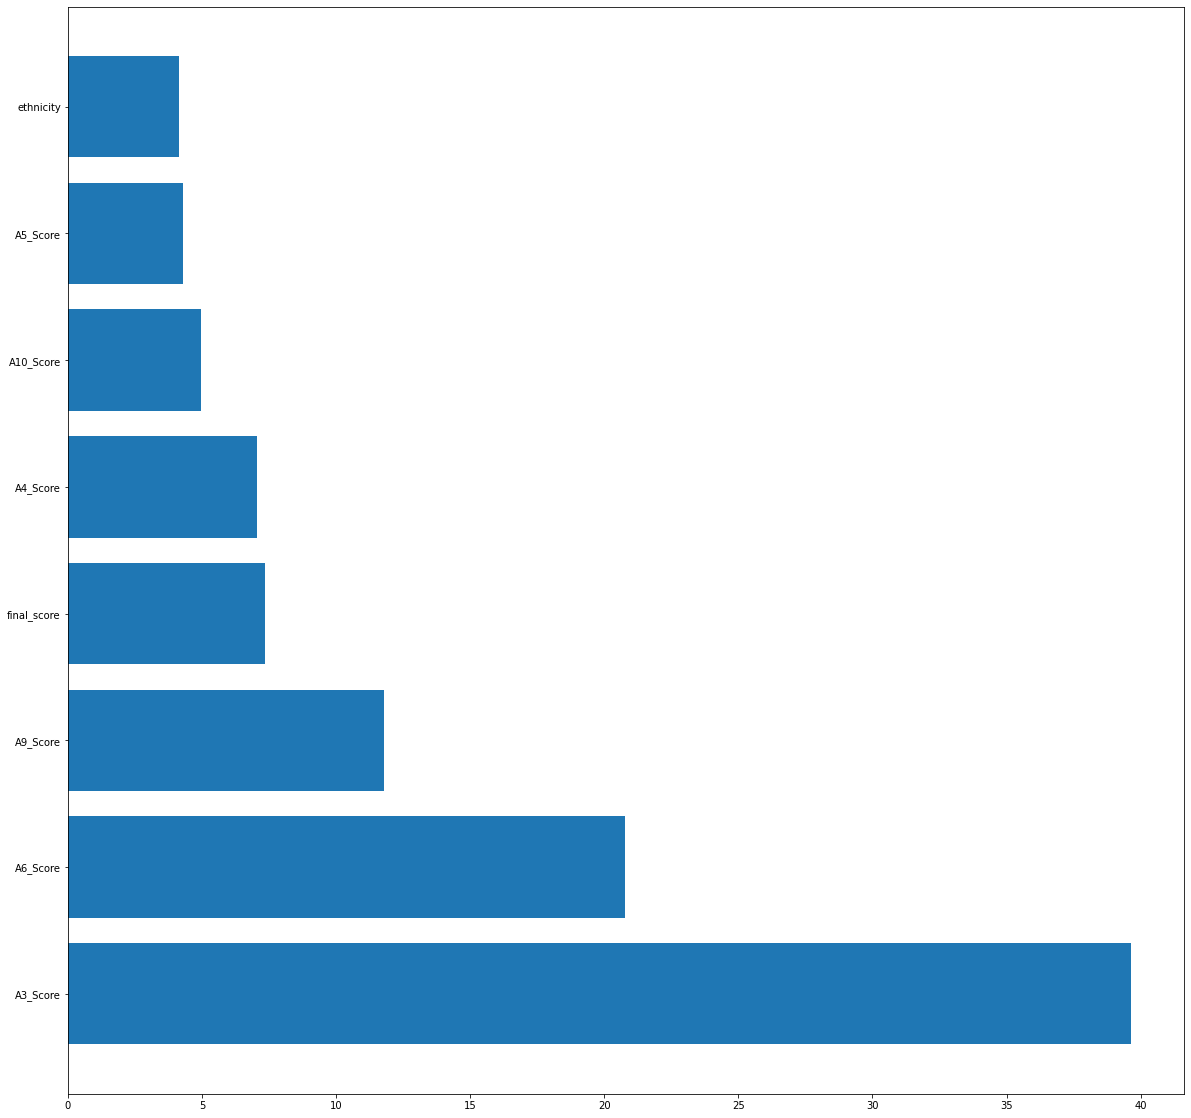

In [153]:
fig = plt.figure(figsize = (20, 20))
plt.barh(feature_importances['Features'], feature_importances['Importances_Percent'])
plt.show()

### 4 - Drop features with importance less than or equal to 4.28

In [155]:
# Drop features
drop_features = get_drop_columns(x_train, 4.28)
x_train = x_train.drop(drop_features, axis=1)
x_valid = x_valid.drop(drop_features, axis=1)

In [156]:
# Find parameters

begin = time.time()
clf = xgb.XGBRegressor(objective ='reg:logistic')

# Create the parameters list you wish to tune, using a dictionary
parameters = {'n_estimators': [20,40,80,100], 'learning_rate': [0.1, 0.01, 0.001, 0.001]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(roc_auc_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train, y_train)).predict(x_valid)
best_predictions = best_clf.predict(x_valid)

unoptimized_train_pred = clf.predict(x_train)
optimized_train_pred = clf.predict(x_train)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("ROC-AUC score on train data: {:.4f}".format(roc_auc_score(y_train, unoptimized_train_pred)))
print("ROC-AUC on testing data: {:.4f}".format(roc_auc_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final ROC-AUC on the train data: {:.4f}".format(roc_auc_score(y_train, optimized_train_pred)))
print("Final ROC-AUC on the testing data: {:.4f}".format(roc_auc_score(y_valid, best_predictions)))

end = time.time()
find_time_taken(begin, end)


Unoptimized model
------
ROC-AUC score on train data: 0.9623
ROC-AUC on testing data: 0.8386

Optimized Model
------
Final ROC-AUC on the train data: 0.9623
Final ROC-AUC on the testing data: 0.8676


Time taken to run this procedure: 3.42 seconds
